In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open('cache_anno/neg_samples.pkl', 'rb') as f:
    neg_samples = pickle.load(f)
with open('cache_anno/waldo.pkl', 'rb') as f:
    pos_waldo = pickle.load(f)
with open('cache_anno/wenda.pkl', 'rb') as f:
    pos_wenda = pickle.load(f)
with open('cache_anno/wizard.pkl', 'rb') as f:
    pos_wizard = pickle.load(f)


## Compute HOG feature descriptor for all samples

Sample image shape (128, 128, 3), feature vector shape (7200,)
Sample image shape (128, 128, 3), feature vector shape (7200,)
Sample image shape (128, 128, 3), feature vector shape (7200,)
Sample image shape (128, 128, 3), feature vector shape (7200,)


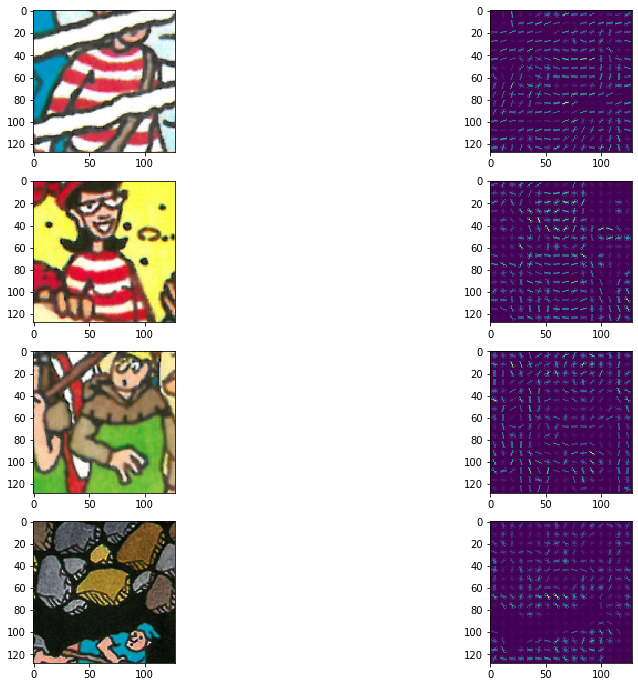

In [4]:
from skimage.feature import hog

# DESCRIPTOR CONFIG
ORIENTATIONS = 8
PIXELS_PER_CELL = (8,8)
CELLS_PER_BLOCK = (2,2)

# viualize the descriptor once for each class
for i, s in enumerate([pos_waldo[0], pos_wenda[0], pos_wizard[0], neg_samples[0]]):
    feature, hog_image = hog(s, orientations=ORIENTATIONS,
                      pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK,
                      visualize=True, multichannel=True)
    print('Sample image shape {}, feature vector shape {}'.format(s.shape, feature.shape))
    plt.subplot(4,2,2*i+1)
    plt.imshow(s)
    plt.subplot(4,2,2*i+2)
    plt.imshow(hog_image)
    
plt.show()

In [5]:
def hog_descriptor(samples):
    f_vects = []
    for s in samples:
        feature = hog(s, orientations=ORIENTATIONS,
                      pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK,
                      visualize=False, multichannel=True)
        f_vects.append(feature)
    return np.array(f_vects)

# transform samples into feature space
pf_wa = hog_descriptor(pos_waldo)
pf_we = hog_descriptor(pos_wenda)
pf_wi = hog_descriptor(pos_wizard)
nf_s = hog_descriptor(neg_samples)

In [13]:
from sklearn.model_selection import train_test_split

labels = {
    'waldo': 0,
    'wenda': 1,
    'wizard': 2,
    'negative' : 3
}

X = np.concatenate((pf_wa, pf_we, pf_wi, nf_s), axis=0)
y = np.concatenate((np.full(pf_wa.shape[0], labels['waldo']),
                    np.full(pf_we.shape[0], labels['wenda']),
                    np.full(pf_wi.shape[0], labels['wizard']),
                    np.full(nf_s.shape[0], labels['negative'])), axis=0)

#X = np.concatenate((pf_wa, nf_s), axis=0)
#y = np.concatenate((np.full(pf_wa.shape[0], labels['waldo']),
#                    np.full(nf_s.shape[0], labels['negative'])), axis=0)

In [17]:
from sklearn import svm
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import cross_val_score


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
print(x_train.shape, y_train.shape)


clf = svm.LinearSVC()
clf.fit(x_train, y_train)

score = clf.score(x_test, y_test)
print('score: {}'.format(score))

(8032, 7200) (8032,)
score: [0.98557214 0.98157371 0.98406375 0.98505976 0.98604187]


In [20]:
print(clf.predict(pf_wa))
print(clf.predict(pf_we))
print(clf.predict(pf_wi))
print(clf.predict(nf_s))

[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 3
 3 0 3 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 3 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 1 1 3 1 1 1 1 1 1 1 3 1 1]
[2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[3 3 3 ... 3 3 3]
